Declaration A

Start by importing bbSearch to perform search algorithms

In [1]:
!echo Installing bbSearch module from web ...
!echo creating bbmodcache subfolder
!mkdir -p bbmodcache
!echo downloading bbSearch module
!curl http://bb-ai.net.s3.amazonaws.com/bb-python-modules/bbSearch.py > bbmodcache/bbSearch.py

from bbmodcache.bbSearch import SearchProblem, search

Installing bbSearch module from web ...
creating bbmodcache subfolder
downloading bbSearch module
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18767  100 18767    0     0   321k      0 --:--:-- --:--:-- --:--:--  321k
Loading bbSearch Version 2.1 (at 18:31, Tue 18 Feb)
Last module source code edit 9am Thursday 24th Feb 2022


Code from Search exercise 7. Creates the grids with their respective blocks and their respective colours

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import deepcopy

plt.ioff()  ## Turn off immediate display of plots

COLORS = ["lightgray", "red", "blue", "green", "yellow",
          "orange", "purple", "pink", "brown"]

class BlockState:

      # Specify mapping from directions to grid coordinate offsets:
      neighbour_offset = {"left": (0,-1), "right": (0,+1), "down":(+1,0), "up":(-1,0)}

      def __init__( self, blockstate, colors=COLORS ):
        self.blockstate = blockstate
        self.nrows = len(blockstate)
        self.ncols = len(blockstate[0])
        self.blocknums = set().union(*[set(row) for row in blockstate])
        self.blocknums = self.blocknums - {0}
        self.blocknumlist = list(self.blocknums)
        self.colors = colors

      def __repr__(self):
        return( str( self.blockstate ))

      # Find the cells occupied by a given number
      def blockcells( self, blocknum ):
          blockcells = []
          for row in range(self.nrows):
            for col in range(self.ncols):
              if self.blockstate[row][col] == blocknum:
                blockcells.append((row,col))
          return blockcells

      # Test if a cell is free (unblocked) in a given direction
      # Free if not blocked by edge of grid or by a cell of different colour
      def free_cell( self, direction, cell ):
        row, col = cell
        offrow, offcol = BlockState.neighbour_offset[direction]
        neighrow, neighcol = (row + offrow, col + offcol)
        if not (0 <= neighrow < self.nrows): return False #at top or bottom
        if not (0 <= neighcol < self.ncols): return False #at left or right
        neighval = self.blockstate[neighrow][neighcol]
        # Neighboring cell must be empty or part of the same coloured block
        return  (neighval==0 or neighval==self.blockstate[row][col])

      def free_block( self, direction, blockn ):
          blockcells = self.blockcells(blockn)
          for cell in blockcells:
            if not self.free_cell(direction, cell):
              return False
          return True

      def possible_moves(self):
        moves = []
        for blocknum in self.blocknumlist:
          for direction in ["left", "right", "down", "up"]:
              if self.free_block(direction, blocknum):
                  moves.append((blocknum, direction))
        return moves

      def next_state(self, move):
          next_blockstate = deepcopy(self.blockstate)
          blockno, direction = move
          cells = self.blockcells(blockno)
          ## first clear all cells of the block (set to 0)
          for cell in cells:
            row, col = cell
            next_blockstate[row][col] = 0
          rowoff, coloff = BlockState.neighbour_offset[direction]
          ## now set all neighbour cells (in move direction) to be
          ## cells with the blocknumber
          for cell in cells:
            row, col = cell
            next_blockstate[row+rowoff][col+coloff] = blockno
          return BlockState(next_blockstate)

      def color_key(self):
          return {b:self.colors[b] for b in self.blocknumlist}

      def figure(self, scale=0.5):
          nrows = self.nrows
          ncols = self.ncols
          fig, ax = plt.subplots(figsize=(ncols*scale+0.1,nrows*scale+0.1))
          plt.close(fig)
          ax.set_axis_off() # Don't show border lines and coordinate values

          frame = patches.Rectangle((0,0),1,1, linewidth=5, edgecolor='k', facecolor='w')
          ax.add_patch(frame)

          for row in range(nrows):
            for col in range(ncols):
                greyrect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                               (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=1, edgecolor="gray", facecolor="lightgray")
                ax.add_patch(greyrect)

          for row in range(nrows):
            for col in range(ncols):
                cellval = self.blockstate[row][col]
                if cellval > 0:
                  cellcol = COLORS[cellval]
                  rect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                             (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=0, edgecolor=cellcol, facecolor=cellcol)
                  ax.add_patch(rect)
          return fig

      def display(self):
          display(self.figure())

In [3]:
from copy import deepcopy
class SlidingBlocksPuzzle( SearchProblem ):

    def __init__( self, initial_state, goal, colors=COLORS ):
        """
        The __init__ method must set the initial state for the search.
        Arguments could be added to __init__ and used to configure the
        initial state and/or other aspects of a problem instance.
        """
        self.initial_state = BlockState(initial_state, colors=colors)
        self.colors = colors
        self.goal = BlockState(goal)

    def info(self):
        print("Solve the following sliding blocks problem.")
        print("Get from this initial state:")
        self.initial_state.display()
        print("To a state incorporating the following block position(s):")
        self.goal.display()
        print("You need to slide the red block to cover the bottom right square.")

    def possible_actions(self, state):
        return state.possible_moves()

    def successor(self, state, action):
        """
        This takes a state and an action and returns the new state resulting
        from doing that action in that state. You can assume that the given
        action is in the list of 'possible_actions' for that state.
        """
        return state.next_state(action)

    def goal_test(self, state):
        """
        For the sliding blocks puzzles, the goal condition is reached when
        all block possitions specified in the given goal state are satisfied by
        the current state. But empty positions (ie 0s) in the goal are ignored,
        so can be occupied by blocks in the current sate.
        """
        for row in range(state.nrows):
          for col in range(state.ncols):
            goalnum = self.goal.blockstate[row][col]
            if goalnum==0:
              continue
            if goalnum != state.blockstate[row][col]:
              return False
        return True


    def cost(self, path, state):
        """
        This is an optional method that you only need to define if you are using
        a cost based algorithm such as "uniform cost" or "A*". It should return
        the cost of reaching a given state via a given path.
        If this is not re-defined, it will is assumed that each action costs one unit
        of effort to perform, so it returns the length of the path.
        """
        return len(path)

    def display_action(self, action):
        """
        You can set the way an action will be displayed in outputs.
        """
        print((self.colors[action[0]], action[1]))

    def display_state(self, state):
        """
        You can set the way a state will be displayed in outputs.
        """
        state.display()

    def display_state_path( self, actions ):
        """
        This defines output of a solution path when a list of actions
        is applied to the initial state. It assumes it is a valid path
        with all actions being possible in the preceeding state.
        You probably don't need to override this.
        """
        s = self.initial_state
        self.display_state(s)
        for a in actions:
            self.display_action(a)
            s = self.successor(s,a)
            self.display_state(s)

After some experimentation we decided to investigate the following cases of Sliding Block Puzzle. We chose a 4x4 grid for the smaller grid as well as an 7x6 grid for the second, larger grid. We placed the same blocks on both grids and the goal for both is to move the red L chaped block to the bottom left of both grid. 

In [4]:
small_initial = [[1,0,0,2],
         [1,1,0,0],
         [0,0,0,4],
         [3,3,0,4]]

small_goal = [[0,0,0,0],
         [0,0,0,0],
         [0,0,1,0],
         [0,0,1,1]]

large_initial = [[1,0,0,0,0,0,2],
         [1,1,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,4],
         [3,3,0,0,0,0,4]]


large_goal = [[0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,1,0],
         [0,0,0,0,0,1,1]]

small_puzzle =  SlidingBlocksPuzzle( small_initial,  small_goal)
large_puzzle =  SlidingBlocksPuzzle( large_initial,  large_goal)

The first test is to show how the size of the grids may effect the time it takes to complete the search as well as how the different search algorithms effect the time and path length. Originally, the large grid was of size 7x8 and we planned on setting the node limit to 5000 which passed for every small grid test. However, the large grid was too large for this small node limit so we increased the limit by 5000 each time and tested if the algorithm passed or failed. Eventually the programs failed as it approched to 50000 nodes. Therefore we reduced the grid size and set the node limit was 30000 for all the tests

Solve the following sliding blocks problem.
Get from this initial state:


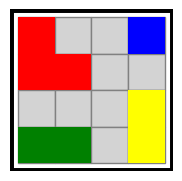

To a state incorporating the following block position(s):


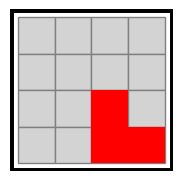

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


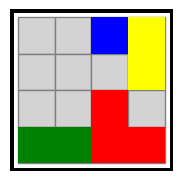

The action path to the solution is:
('red', 'right')
('red', 'down')
('blue', 'left')
('yellow', 'up')
('yellow', 'up')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =     2134  (includes start)
Nodes discarded by loop_check  =     1641  (493 distinct states added to queue)
Nodes tested (by goal_test)    =      356  (355 expanded + 1 goal)
Nodes left in queue            =      137

Time taken = 0.0728 seconds

Solve the following sliding blocks problem.
Get from this initial state:


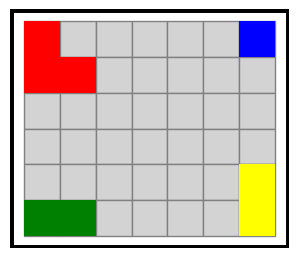

To a state incorporating the following block position(s):


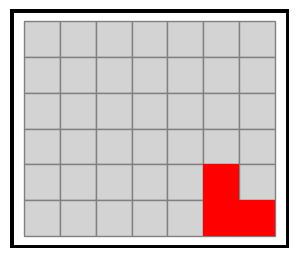

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 10
Goal state is:


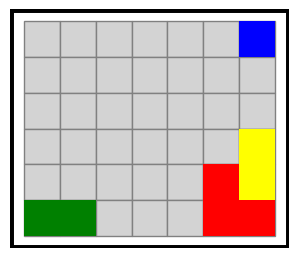

The action path to the solution is:
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'down')
('red', 'down')
('red', 'down')
('yellow', 'up')
('red', 'right')


SEARCH SPACE STATS:
Total nodes generated          =   185417  (includes start)
Nodes discarded by loop_check  =   158676  (26741 distinct states added to queue)
Nodes tested (by goal_test)    =    16547  (16546 expanded + 1 goal)
Nodes left in queue            =    10194

Time taken = 6.1856 seconds



In [5]:
small_search = search( small_puzzle, 'BF/FIFO', 30000, loop_check=True, randomise=False, return_info=True)
large_search = search( large_puzzle, 'BF/FIFO', 30000, loop_check=True, randomise=False, return_info=True)

This test is for Depth first search. The small gird passed successfully however, the larger grid did not so we increased the node limit to 35000 to see at what point it would pass.

Solve the following sliding blocks problem.
Get from this initial state:


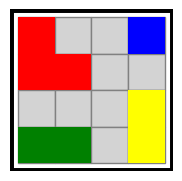

To a state incorporating the following block position(s):


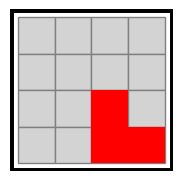

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 78
Goal state is:


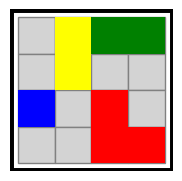

The action path to the solution is:
('yellow', 'up')
('yellow', 'left')
('yellow', 'up')
('green', 'up')
('green', 'right')
('green', 'right')
('green', 'down')
('yellow', 'down')
('yellow', 'right')
('blue', 'left')
('yellow', 'up')
('green', 'up')
('green', 'left')
('yellow', 'down')
('yellow', 'down')
('green', 'down')
('blue', 'down')
('yellow', 'up')
('yellow', 'up')
('green', 'left')
('green', 'up')
('yellow', 'down')
('yellow', 'down')
('yellow', 'left')
('green', 'down')
('blue', 'up')
('blue', 'left')
('yellow', 'up')
('yellow', 'up')
('yellow', 'right')
('green', 'right')
('yellow', 'down')
('red', 'down')
('yellow', 'down')
('green', 'left')
('blue', 'down')
('yellow', 'up')
('yellow', 'up')
('yellow', 'left')
('green', 'right')
('yellow', 'down')
('green', 'right')
('yellow', 'right')
('yellow', 'up')
('green', 'up')
('yellow', 'left')
('blue', 'up')
('green', 'down')
('blue', 'left')
('yellow', 'down')
('yellow', 'right')
('red', 'down')
('yellow', 'up')
('green', 'up')
('

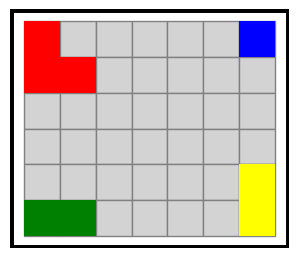

To a state incorporating the following block position(s):


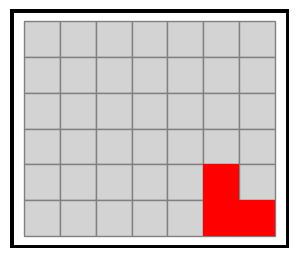

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...
!! Search node limit (30000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =    43931  (includes start)
Nodes discarded by loop_check  =    13930  (30001 distinct states added to queue)
Nodes tested (by goal_test)    =     3982  (all expanded)
Nodes left in queue            =    26018

Time taken = 3.8538 seconds

Solve the following sliding blocks problem.
Get from this initial state:


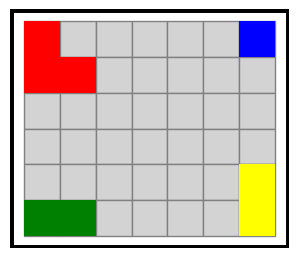

To a state incorporating the following block position(s):


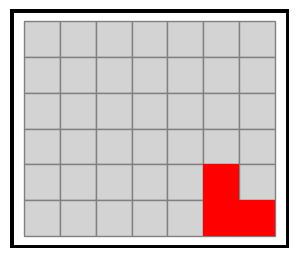

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 35000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 663
Goal state is:


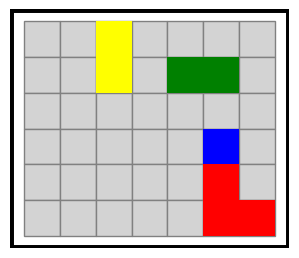

The action path to the solution is:
('red', 'right')
('blue', 'down')
('blue', 'down')
('blue', 'left')
('red', 'left')
('green', 'right')
('blue', 'right')
('green', 'up')
('green', 'right')
('green', 'right')
('green', 'up')
('yellow', 'left')
('blue', 'down')
('green', 'up')
('yellow', 'left')
('green', 'up')
('green', 'right')
('green', 'right')
('blue', 'down')
('red', 'right')
('yellow', 'up')
('green', 'left')
('yellow', 'right')
('green', 'up')
('blue', 'down')
('green', 'right')
('red', 'left')
('yellow', 'right')
('yellow', 'up')
('yellow', 'up')
('green', 'left')
('yellow', 'left')
('blue', 'left')
('green', 'right')
('blue', 'left')
('red', 'right')
('yellow', 'down')
('green', 'left')
('red', 'down')
('yellow', 'left')
('green', 'down')
('yellow', 'down')
('red', 'left')
('red', 'up')
('green', 'right')
('red', 'right')
('yellow', 'left')
('green', 'up')
('blue', 'up')
('yellow', 'down')
('green', 'left')
('red', 'left')
('yellow', 'left')
('blue', 'up')
('green', 'down')


In [6]:
small_Df = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=False, return_info=True)
large_DF = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=False, return_info=True)
large_DF2 = search( large_puzzle, 'DF/LIFO', 35000, loop_check=True, randomise=True, return_info=True)

This is the same as the depth first test but randomise is true

Solve the following sliding blocks problem.
Get from this initial state:


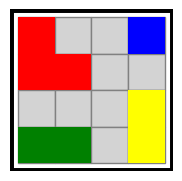

To a state incorporating the following block position(s):


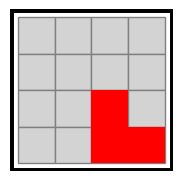

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 83
Goal state is:


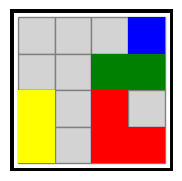

The action path to the solution is:
('red', 'right')
('green', 'right')
('red', 'down')
('blue', 'left')
('blue', 'left')
('blue', 'left')
('red', 'left')
('green', 'left')
('blue', 'right')
('red', 'up')
('yellow', 'left')
('yellow', 'up')
('yellow', 'up')
('yellow', 'right')
('green', 'up')
('yellow', 'down')
('green', 'right')
('blue', 'right')
('green', 'down')
('yellow', 'down')
('blue', 'down')
('blue', 'right')
('red', 'down')
('green', 'left')
('red', 'right')
('blue', 'left')
('yellow', 'up')
('green', 'right')
('green', 'right')
('blue', 'up')
('blue', 'left')
('blue', 'left')
('red', 'left')
('yellow', 'up')
('green', 'left')
('blue', 'right')
('blue', 'right')
('red', 'right')
('red', 'up')
('green', 'right')
('green', 'up')
('red', 'left')
('red', 'down')
('red', 'down')
('green', 'down')
('blue', 'down')
('blue', 'left')
('green', 'up')
('yellow', 'left')
('blue', 'up')
('red', 'up')
('red', 'up')
('green', 'down')
('yellow', 'down')
('red', 'down')
('blue', 'right')
('bl

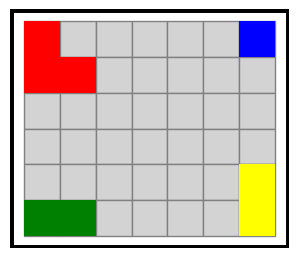

To a state incorporating the following block position(s):


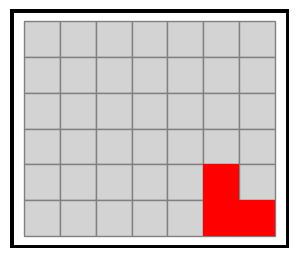

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 228
Goal state is:


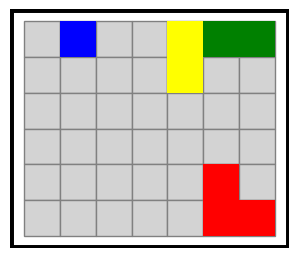

The action path to the solution is:
('yellow', 'up')
('red', 'down')
('green', 'right')
('green', 'up')
('blue', 'down')
('yellow', 'left')
('blue', 'down')
('blue', 'down')
('red', 'down')
('green', 'right')
('yellow', 'left')
('red', 'down')
('green', 'down')
('blue', 'left')
('green', 'left')
('green', 'left')
('blue', 'right')
('blue', 'down')
('blue', 'down')
('yellow', 'up')
('red', 'right')
('yellow', 'up')
('yellow', 'up')
('yellow', 'left')
('yellow', 'left')
('blue', 'left')
('yellow', 'down')
('yellow', 'right')
('red', 'right')
('blue', 'right')
('blue', 'up')
('blue', 'up')
('yellow', 'left')
('blue', 'left')
('yellow', 'left')
('blue', 'left')
('yellow', 'down')
('blue', 'up')
('blue', 'right')
('green', 'right')
('yellow', 'left')
('blue', 'down')
('blue', 'right')
('green', 'right')
('red', 'up')
('blue', 'down')
('yellow', 'up')
('green', 'up')
('blue', 'left')
('blue', 'down')
('red', 'right')
('yellow', 'down')
('green', 'down')
('yellow', 'down')
('blue', 'right')
(

In [7]:
small_DFR = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True)
large_DFR = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True)

We have no introduced the cost aspect of the search. This cost function is from Search Exercise 6

Solve the following sliding blocks problem.
Get from this initial state:


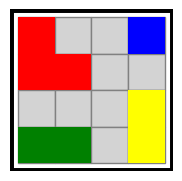

To a state incorporating the following block position(s):


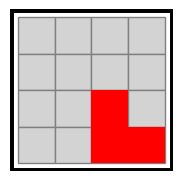

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=cost, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


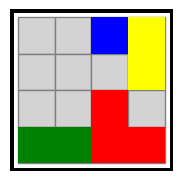

Cost of reaching goal: 7
The action path to the solution is:
('red', 'right')
('red', 'down')
('blue', 'left')
('yellow', 'up')
('yellow', 'up')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =     2134  (includes start)
Nodes discarded by loop_check  =     1641  (493 distinct states added to queue)
Nodes tested (by goal_test)    =      356  (355 expanded + 1 goal)
Nodes left in queue            =      137

Time taken = 0.0834 seconds

Solve the following sliding blocks problem.
Get from this initial state:


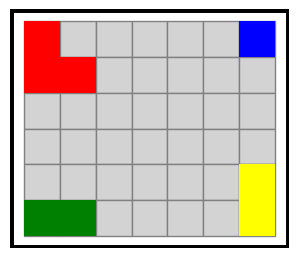

To a state incorporating the following block position(s):


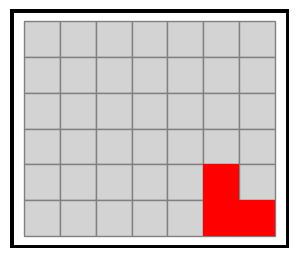

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=cost, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 10
Goal state is:


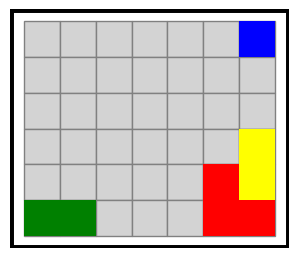

Cost of reaching goal: 10
The action path to the solution is:
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'down')
('red', 'down')
('red', 'down')
('yellow', 'up')
('red', 'right')


SEARCH SPACE STATS:
Total nodes generated          =   185417  (includes start)
Nodes discarded by loop_check  =   158676  (26741 distinct states added to queue)
Nodes tested (by goal_test)    =    16547  (16546 expanded + 1 goal)
Nodes left in queue            =    10194

Time taken = 6.5357 seconds



In [8]:
def cost(path, state):
        return len(path)

small_cost = search(small_puzzle, 'BF/FIFO', 30000, cost=cost, loop_check=True, return_info=True)
large_cost = search(large_puzzle, 'BF/FIFO', 30000, cost=cost, loop_check=True, return_info=True)

This A* algorithm uses the cost function from before and now uses heuristics. This heuristic is from Search Exercise 7

Solve the following sliding blocks problem.
Get from this initial state:


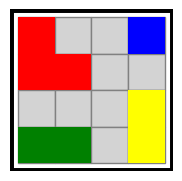

To a state incorporating the following block position(s):


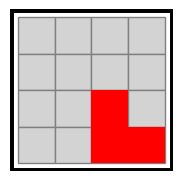

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=red_right_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)



:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


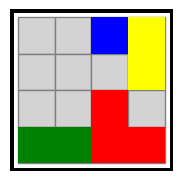

Cost of reaching goal: 7
The action path to the solution is:
('red', 'right')
('blue', 'left')
('yellow', 'up')
('yellow', 'up')
('red', 'down')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =     1154  (includes start)
Nodes discarded by loop_check  =      854  (300 distinct states added to queue)
Nodes tested (by goal_test)    =      194  (193 expanded + 1 goal)
Nodes left in queue            =      106

Time taken = 0.0579 seconds

Solve the following sliding blocks problem.
Get from this initial state:


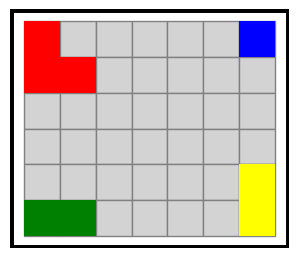

To a state incorporating the following block position(s):


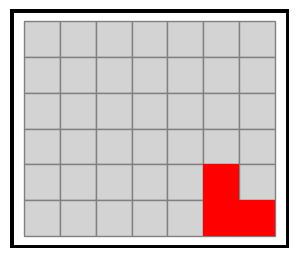

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=red_right_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.
:-)) *SUCCESS* ((-:

Path length = 10
Goal state is:


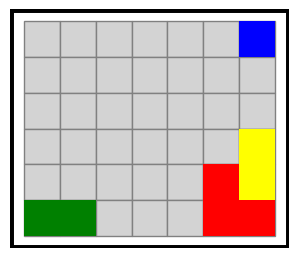

Cost of reaching goal: 10
The action path to the solution is:
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'down')
('red', 'down')
('yellow', 'up')
('red', 'down')
('red', 'right')


SEARCH SPACE STATS:
Total nodes generated          =    20218  (includes start)
Nodes discarded by loop_check  =    15927  (4291 distinct states added to queue)
Nodes tested (by goal_test)    =     1928  (1927 expanded + 1 goal)
Nodes left in queue            =     2363

Time taken = 0.668 seconds



In [9]:
def red_right_heuristic(state):
    for row in state.blockstate:
      for i, col in enumerate(row):
          if col == 1:
            return 6-i

small_A = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=red_right_heuristic)
large_A = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=red_right_heuristic)


This table shows a summary of every test that was just performed and it is from Search Exercise 7. From the results, all the large tests failed with the low node limit of 5000.

In [10]:
TEST_RESULTS =[small_search, large_search, small_Df, large_DF, large_DF2, small_DFR, large_DFR,small_A, large_A]

# Specify symbols for termination conditions:
short_tc = {"GOAL_STATE_FOUND"     : "Y",
            "NODE_LIMIT_EXCEEDED"  : "!",
            "SEARH-SPACE_EXHAUSTED": "x"}

print("\n                **TESTS SUMMARY**\n")

print("Test    #max   Result   #gen     #inQ    Time s")
for i, test in enumerate(TEST_RESULTS):
    max  = test['args']['max_nodes']
    tc  = test['result']['termination_condition']
    stc = short_tc[tc]

    ng  = test['search_stats']['nodes_generated']
    nq  = test['search_stats']['nodes_left_in_queue']
    time = round( test['search_stats']['time_taken'], 2 )
    print( f"{i:>3}: {max:>8}    {stc}  {ng:>8} {nq:>8}     {time} ")


                **TESTS SUMMARY**

Test    #max   Result   #gen     #inQ    Time s
  0:    30000    Y      2134      137     0.07 
  1:    30000    Y    185417    10194     6.19 
  2:    30000    Y       472      192     0.04 
  3:    30000    !     43931    26018     3.85 
  4:    35000    Y      7544     5517     1.69 
  5:    30000    Y       506      232     0.04 
  6:    30000    Y      2522     1824     0.26 
  7:    30000    Y      1154      106     0.06 
  8:    30000    Y     20218     2363     0.67 


## Heuristics

Continuing to look at the impact of heuristics on our search algorithms, we have chosen to look at the *Manhattan Distance Heuristic* which calculates the sum of horizontal and vertical distances of the block from goal state.

Solve the following sliding blocks problem.
Get from this initial state:


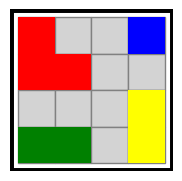

To a state incorporating the following block position(s):


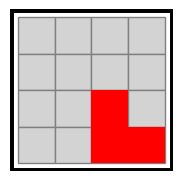

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=manhattan_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


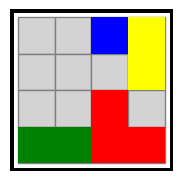

Cost of reaching goal: 7
The action path to the solution is:
('red', 'right')
('red', 'down')
('yellow', 'up')
('blue', 'left')
('yellow', 'up')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =      145  (includes start)
Nodes discarded by loop_check  =       65  (80 distinct states added to queue)
Nodes tested (by goal_test)    =       27  (26 expanded + 1 goal)
Nodes left in queue            =       53

Time taken = 0.0398 seconds

Solve the following sliding blocks problem.
Get from this initial state:


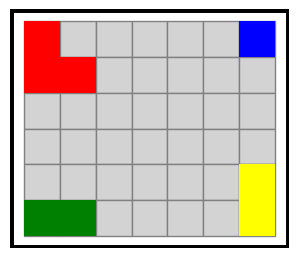

To a state incorporating the following block position(s):


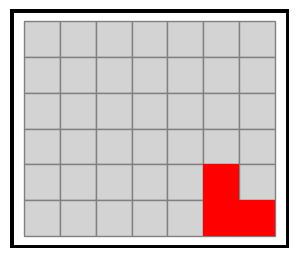

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=manhattan_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 10
Goal state is:


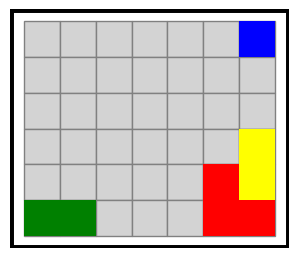

Cost of reaching goal: 10
The action path to the solution is:
('red', 'down')
('red', 'down')
('red', 'right')
('red', 'down')
('red', 'right')
('red', 'down')
('red', 'right')
('red', 'right')
('yellow', 'up')
('red', 'right')


SEARCH SPACE STATS:
Total nodes generated          =       96  (includes start)
Nodes discarded by loop_check  =       17  (79 distinct states added to queue)
Nodes tested (by goal_test)    =       12  (11 expanded + 1 goal)
Nodes left in queue            =       67

Time taken = 0.0548 seconds



In [11]:
def manhattan_heuristic(state):
    goal_r, goal_c = len(state.blockstate) - 1, len(state.blockstate[0]) - 1  # Bottom-right corner
    
    total = 0
    for row in range(state.nrows):
        for col in range(state.ncols):
            if state.blockstate[row][col] == 1:  # Find red block tiles
                total += abs(goal_r - row) + abs(goal_c - col)
    
    return total

small_manhattan = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=manhattan_heuristic)
large_manhattan = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=manhattan_heuristic)

Another test wanted to create a heuristic for is the calculation of free space around the goal position.


Solve the following sliding blocks problem.
Get from this initial state:


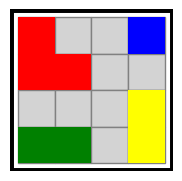

To a state incorporating the following block position(s):


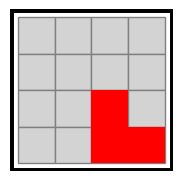

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=free_space_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


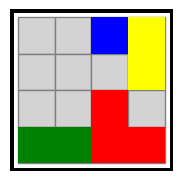

Cost of reaching goal: 7
The action path to the solution is:
('yellow', 'up')
('blue', 'left')
('yellow', 'up')
('red', 'right')
('red', 'down')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =     1002  (includes start)
Nodes discarded by loop_check  =      705  (297 distinct states added to queue)
Nodes tested (by goal_test)    =      168  (167 expanded + 1 goal)
Nodes left in queue            =      129

Time taken = 0.0503 seconds

Solve the following sliding blocks problem.
Get from this initial state:


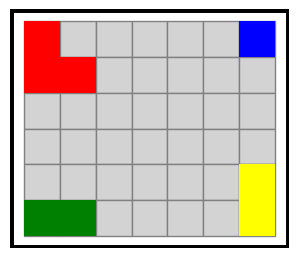

To a state incorporating the following block position(s):


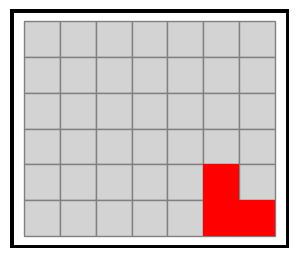

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=free_space_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.
:-)) *SUCCESS* ((-:

Path length = 11
Goal state is:


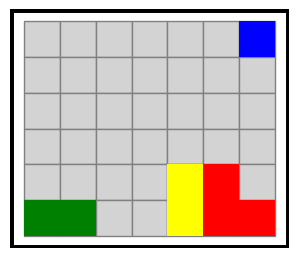

Cost of reaching goal: 11
The action path to the solution is:
('red', 'right')
('yellow', 'left')
('yellow', 'left')
('red', 'down')
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'right')
('red', 'down')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    17571  (includes start)
Nodes discarded by loop_check  =    12836  (4735 distinct states added to queue)
Nodes tested (by goal_test)    =     1676  (1675 expanded + 1 goal)
Nodes left in queue            =     3059

Time taken = 0.7602 seconds



In [12]:
def free_space_heuristic(state):
    # Goal position: bottom-right corner of the grid
    goal_r, goal_c = len(state.blockstate) - 1, len(state.blockstate[0]) - 1
    
    # Find the current position of the red block
    red_block_pos = None
    for r in range(len(state.blockstate)):
        for c in range(len(state.blockstate[r])):
            if state.blockstate[r][c] == 1:  # red block position
                red_block_pos = (r, c)
                break
        if red_block_pos:
            break
    
    # Calculate the Manhattan distance from the red block to the goal
    red_r, red_c = red_block_pos
    manhattan_distance = abs(red_r - goal_r) + abs(red_c - goal_c)
    
    # Count empty spaces around the goal (bottom-right corner)
    empty_spaces = 0
    for dr in [-1, 0, 1]:  # Check above, same row, and below
        for dc in [-1, 0, 1]:  # Check left, same column, and right
            r, c = goal_r + dr, goal_c + dc
            if 0 <= r < len(state.blockstate) and 0 <= c < len(state.blockstate[0]):
                if state.blockstate[r][c] == 0:  # Empty space
                    empty_spaces += 1
    
    # Return the heuristic value: combine Manhattan distance and free space
    return manhattan_distance - empty_spaces

small_free_space = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=free_space_heuristic)
large_free_space = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=free_space_heuristic)

In a similar fashion to the previously used *red_right_heuristic*, we wanted to test whether prioritising movement of the red block downwards would impact efficiency.

Solve the following sliding blocks problem.
Get from this initial state:


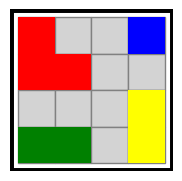

To a state incorporating the following block position(s):


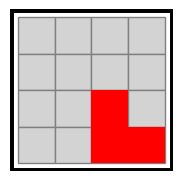

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=red_down_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


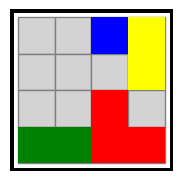

Cost of reaching goal: 7
The action path to the solution is:
('red', 'down')
('yellow', 'up')
('blue', 'left')
('yellow', 'up')
('red', 'right')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =     1229  (includes start)
Nodes discarded by loop_check  =      921  (308 distinct states added to queue)
Nodes tested (by goal_test)    =      201  (200 expanded + 1 goal)
Nodes left in queue            =      107

Time taken = 0.0604 seconds

Solve the following sliding blocks problem.
Get from this initial state:


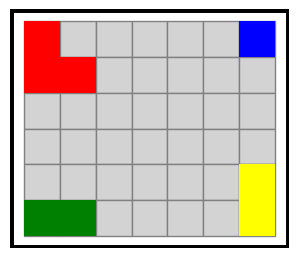

To a state incorporating the following block position(s):


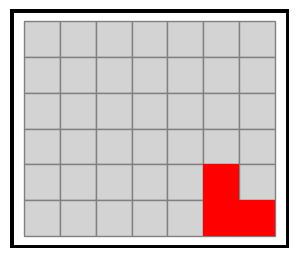

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=red_down_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.....
:-)) *SUCCESS* ((-:

Path length = 10
Goal state is:


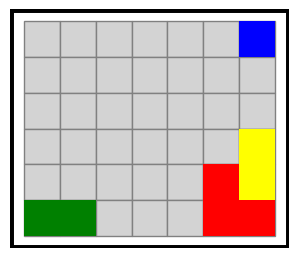

Cost of reaching goal: 10
The action path to the solution is:
('red', 'down')
('red', 'down')
('red', 'down')
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'right')
('red', 'right')
('yellow', 'up')
('red', 'right')


SEARCH SPACE STATS:
Total nodes generated          =    59491  (includes start)
Nodes discarded by loop_check  =    49130  (10361 distinct states added to queue)
Nodes tested (by goal_test)    =     5393  (5392 expanded + 1 goal)
Nodes left in queue            =     4968

Time taken = 2.2892 seconds



In [13]:
def red_down_heuristic(state):
    for i, row in enumerate(state.blockstate):
        if 1 in row: # Red block found
            return len(state.blockstate) - i  # Distance from bottom
    return 0  # Default if not found

small_red_down = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=red_down_heuristic)
large_red_down = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=red_down_heuristic)

This heuristic encourages the movement of the red block *diagonally* towards the goal state.

Solve the following sliding blocks problem.
Get from this initial state:


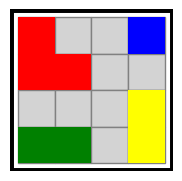

To a state incorporating the following block position(s):


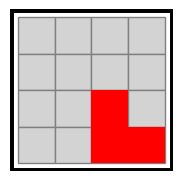

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=red_bottom_right_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


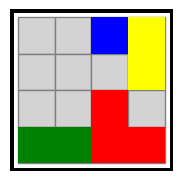

Cost of reaching goal: 7
The action path to the solution is:
('red', 'down')
('red', 'right')
('blue', 'left')
('yellow', 'up')
('yellow', 'up')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =      563  (includes start)
Nodes discarded by loop_check  =      404  (159 distinct states added to queue)
Nodes tested (by goal_test)    =       94  (93 expanded + 1 goal)
Nodes left in queue            =       65

Time taken = 0.0438 seconds

Solve the following sliding blocks problem.
Get from this initial state:


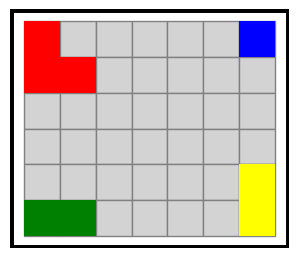

To a state incorporating the following block position(s):


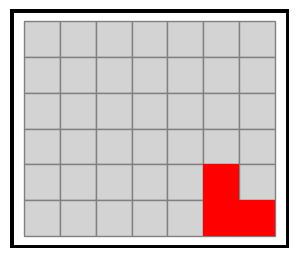

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=red_bottom_right_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 10
Goal state is:


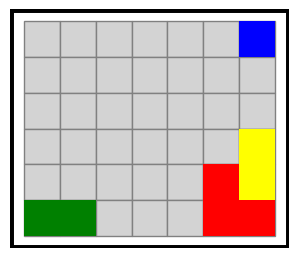

Cost of reaching goal: 10
The action path to the solution is:
('red', 'down')
('red', 'down')
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'right')
('red', 'right')
('red', 'down')
('yellow', 'up')
('red', 'right')


SEARCH SPACE STATS:
Total nodes generated          =     1021  (includes start)
Nodes discarded by loop_check  =      562  (459 distinct states added to queue)
Nodes tested (by goal_test)    =      110  (109 expanded + 1 goal)
Nodes left in queue            =      349

Time taken = 0.1782 seconds



In [14]:
def red_bottom_right_heuristic(state):
    for r, row in enumerate(state.blockstate):
        for c, col in enumerate(row):
            if col == 1:  # Find red block
                return (len(state.blockstate) - r) + (len(row) - c)  # Distance from bottom-right
    return 0  # Default if not found

small_red_bottom_right = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=red_bottom_right_heuristic)
large_red_bottom_right = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=red_bottom_right_heuristic)

Here is a summary of the results for any heuristic based tests.

In [15]:
TEST_RESULTS =[small_A, large_A, small_manhattan, large_manhattan, small_free_space, large_free_space, small_red_down, large_red_down ,small_red_bottom_right, large_red_bottom_right]

# Specify symbols for termination conditions:
short_tc = {"GOAL_STATE_FOUND"     : "Y",
            "NODE_LIMIT_EXCEEDED"  : "!",
            "SEARH-SPACE_EXHAUSTED": "x"}

print("\n                **TESTS SUMMARY**\n")

print("Test    #max   Result   #gen     #inQ    Time s")
for i, test in enumerate(TEST_RESULTS):
    max  = test['args']['max_nodes']
    tc  = test['result']['termination_condition']
    stc = short_tc[tc]

    ng  = test['search_stats']['nodes_generated']
    nq  = test['search_stats']['nodes_left_in_queue']
    time = round( test['search_stats']['time_taken'], 2 )
    print( f"{i:>3}: {max:>8}    {stc}  {ng:>8} {nq:>8}     {time} ")


                **TESTS SUMMARY**

Test    #max   Result   #gen     #inQ    Time s
  0:    30000    Y      1154      106     0.06 
  1:    30000    Y     20218     2363     0.67 
  2:    30000    Y       145       53     0.04 
  3:    30000    Y        96       67     0.05 
  4:    30000    Y      1002      129     0.05 
  5:    30000    Y     17571     3059     0.76 
  6:    30000    Y      1229      107     0.06 
  7:    30000    Y     59491     4968     2.29 
  8:    30000    Y       563       65     0.04 
  9:    30000    Y      1021      349     0.18 
